# Castile and Leon: Crops

### Description:
TODO

### Author:
Sergio García Prado ([garciparedes.me](https://garciparedes.me))

In [1]:
rm(list = ls())

In [2]:
library(readr)
library(ggplot2)
library(dplyr)
library(tidyr)
library(RSocrata)
library(ca)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Data Adquisition:

In [3]:
my.read.csv <- function(url, filename) {
    if (!file.exists(filename)) {
        write_csv(read.socrata(url), filename)
    }
    return(read_csv(filename))
}

In [4]:
crops.herbaceous <- my.read.csv("https://analisis.datosabiertos.jcyl.es/resource/agu2-cspz.csv",
                               "./data/crops-herbaceous.csv")

Parsed with column specification:
cols(
  a_o = col_integer(),
  codigo_comarca = col_integer(),
  codigo_muncipio = col_integer(),
  codigo_producto = col_character(),
  codigo_provincia = col_integer(),
  comarca = col_character(),
  cultivo = col_character(),
  grupo_de_cultivo = col_character(),
  municipio = col_character(),
  ocupaci_n_primera_regad_o = col_integer(),
  ocupaci_n_primera_secano = col_integer(),
  ocupaciones_asociadas_regad_o = col_character(),
  ocupaciones_asociadas_secano = col_character(),
  ocupaciones_posteriores_regad_o = col_character(),
  ocupaciones_posteriores_secano = col_character()
)


In [5]:
crops.woody <- my.read.csv("https://analisis.datosabiertos.jcyl.es/resource/2vwa-si9n.csv",
                           "./data/crops-woody.csv")

Parsed with column specification:
cols(
  a_o = col_datetime(format = ""),
  codigo_comarca = col_integer(),
  codigo_muncipio = col_integer(),
  codigo_producto = col_character(),
  codigo_provincia = col_integer(),
  comarca = col_character(),
  cultivo = col_character(),
  grupo_de_cultivo = col_character(),
  municipio = col_character(),
  n_total_arboles_diseminados = col_integer(),
  superficie_regad_o_en_producci_n = col_integer(),
  superficie_regad_o_que_no_pruduce = col_integer(),
  superficie_secano_en_producci_n = col_integer(),
  superficie_secano_que_no_pruduce = col_integer()
)


## Data Exploration:

In [6]:
colnames(crops.herbaceous)

[1] "a_o"                             "codigo_comarca"                 
 [3] "codigo_muncipio"                 "codigo_producto"                
 [5] "codigo_provincia"                "comarca"                        
 [7] "cultivo"                         "grupo_de_cultivo"               
 [9] "municipio"                       "ocupaci_n_primera_regad_o"      
[11] "ocupaci_n_primera_secano"        "ocupaciones_asociadas_regad_o"  
[13] "ocupaciones_asociadas_secano"    "ocupaciones_posteriores_regad_o"
[15] "ocupaciones_posteriores_secano"

#### Remove Unnecesary Columns and Rename Interesting Columns

In [7]:
code.province.to.province <- function(code) {
    return(switch(as.character(code),
           "47" = "Valladolid",
           "24" = "León",
           "34" = "Palencia",
           "37" = "Salamanca",
           "9"  = "Burgos",
           "49" = "Zamora",
           "5"  = "Ávila",
           "42" = "Soria",
           "40" = "Segovia"))
}

In [8]:
crops.herbaceous.use <- crops.herbaceous %>%
    select(a_o, codigo_provincia:ocupaci_n_primera_secano) %>%
    rename(year = a_o, 
           code.province = codigo_provincia, 
           region = comarca, 
           crop = cultivo, 
           crop.type = grupo_de_cultivo, 
           town = municipio, 
           area.irrigation = ocupaci_n_primera_regad_o, 
           area.dry = ocupaci_n_primera_secano) %>%
    mutate(province = sapply(code.province,code.province.to.province)) %>%
    select(-code.province)

#### View Data Sample

In [9]:
sample_n(crops.herbaceous.use, 10)

year,region,crop,crop.type,town,area.irrigation,area.dry,province
2013,CUELLAR,PATATA TARDIA,TUBERCULOS,CARBONERO EL MAYOR,2,NA,Segovia
2016,TIERRA DE CAMPOS,VEZA PARA FORRAJE,CULTIVOS FORRAJEROS,VILLAGOMEZ LA NUEVA,0,84,Valladolid
2014,PEÑARADA DE BRACAMONTE,PATATA MED. ESTACION,TUBERCULOS,ZORITA DE LA FRONTERA,12,NA,Salamanca
2016,BUREBA-EBRO,AVENA,CEREALES GRANO,QUINTANILLA SAN GARCIA,0,2,Burgos
2014,BENAVENTE Y LOS VALLES,CEREALES PARA FORRAJ,CULTIVOS FORRAJEROS,GRANUCILLO,0,24,Zamora
2011,AREVALO-MADRIGAL,VEZA PARA FORRAJE,CULTIVOS FORRAJEROS,ALDEASECA,2,7,Ávila
2014,BENAVENTE Y LOS VALLES,ALGARROBA,LEGUMINOSAS GRANO,GRANJA DE MORERUELA,21,27,Zamora
2012,SUR,JUDIA SECA,LEGUMINOSAS GRANO,MEDINA DEL CAMPO,8,0,Valladolid
2014,SALDAÑA-VALDAVIA,AVENA,CEREALES GRANO,VILLAMORONTA,1,38,Palencia
2015,SALAMANCA,CEREALES PARA FORRAJ,CULTIVOS FORRAJEROS,CANILLAS DE ABAJO,NA,350,Salamanca


In [10]:
summary(crops.herbaceous.use)

      year         region              crop            crop.type        
 Min.   :2010   Length:157965      Length:157965      Length:157965     
 1st Qu.:2011   Class :character   Class :character   Class :character  
 Median :2013   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2013                                                           
 3rd Qu.:2015                                                           
 Max.   :2016                                                           
                                                                        
     town           area.irrigation      area.dry         province        
 Length:157965      Min.   :   0.00   Min.   :    0.0   Length:157965     
 Class :character   1st Qu.:   0.00   1st Qu.:    3.0   Class :character  
 Mode  :character   Median :   3.00   Median :   18.0   Mode  :character  
                    Mean   :  29.76   Mean   :  119.9                     
                    3rd Qu.:  19.00   3rd

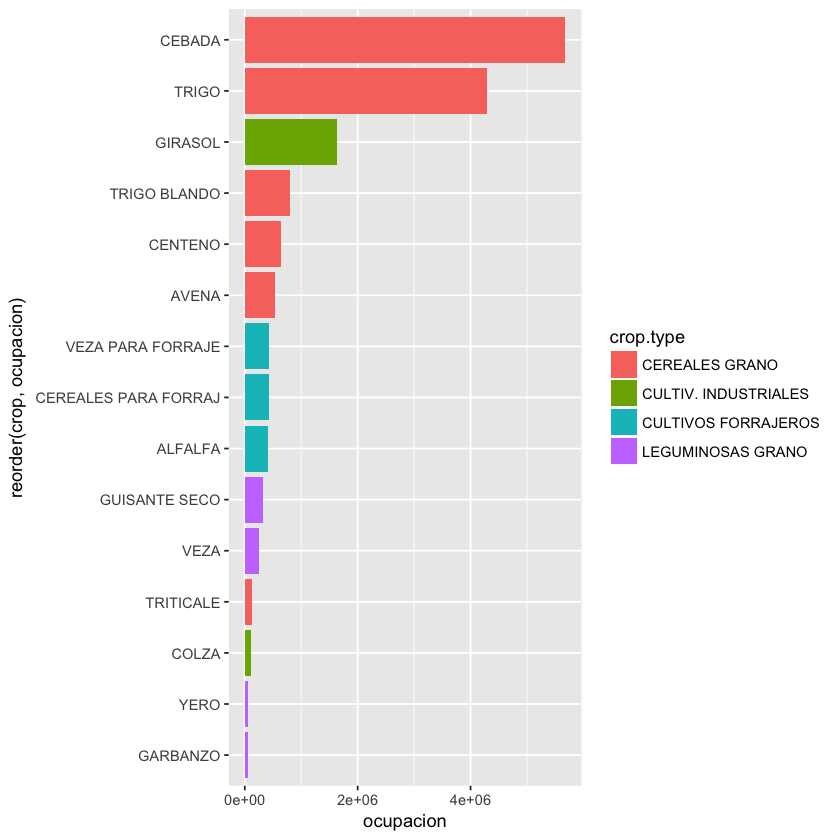

In [11]:
crops.herbaceous.use %>%
  select(crop, crop.type, area.dry) %>%
  filter(area.dry > 0) %>%
  group_by(crop.type, crop) %>%
  summarise(ocupacion = sum(area.dry, na.rm = TRUE)) %>%
  ungroup() %>%
  top_n(15, ocupacion) %>%
  ggplot(aes(x = reorder(crop, ocupacion), y = ocupacion)) + 
    geom_bar(aes(fill = crop.type), stat = "identity") + 
    coord_flip()

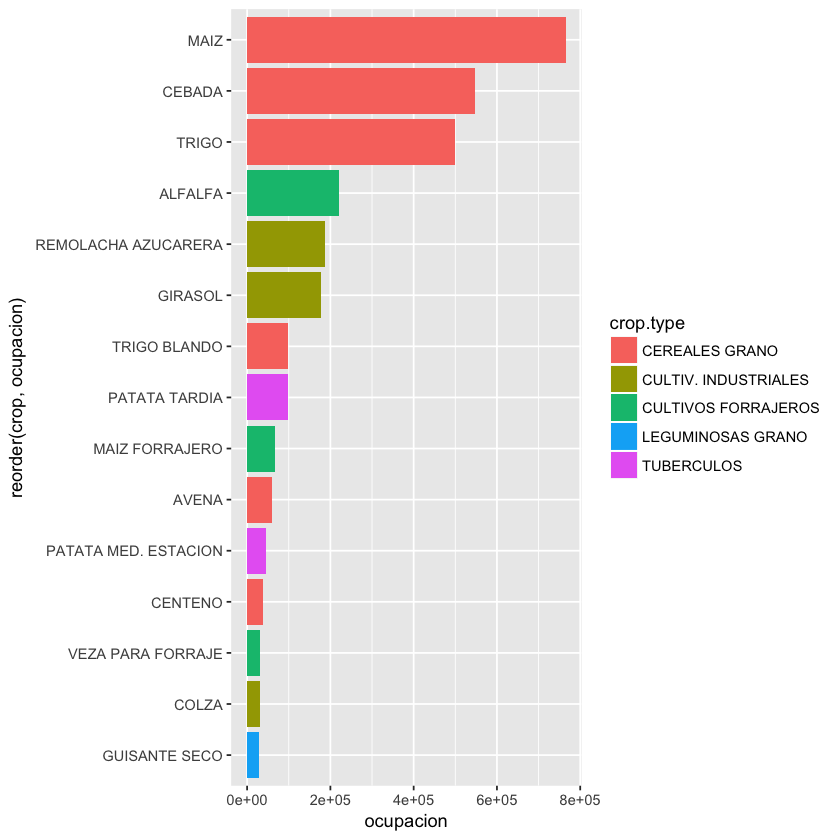

In [12]:
crops.herbaceous.use %>%
  select(crop, crop.type, area.irrigation) %>%
  group_by(crop.type, crop) %>%
  summarise(ocupacion = sum(area.irrigation, na.rm = TRUE)) %>%
  ungroup() %>%
  top_n(15, ocupacion) %>%
  ggplot(aes(x = reorder(crop, ocupacion), y = ocupacion)) + 
    geom_bar(aes(fill = crop.type), stat = "identity") + 
    coord_flip()

### Correspondence Analysis

In [13]:
crops.herbaceous.use.ca <- crops.herbaceous.use %>%
    select(crop.type, province, area.dry) %>%
    filter(area.dry > 0) %>%
    xtabs(formula = area.dry ~ .) %>%
    ca()

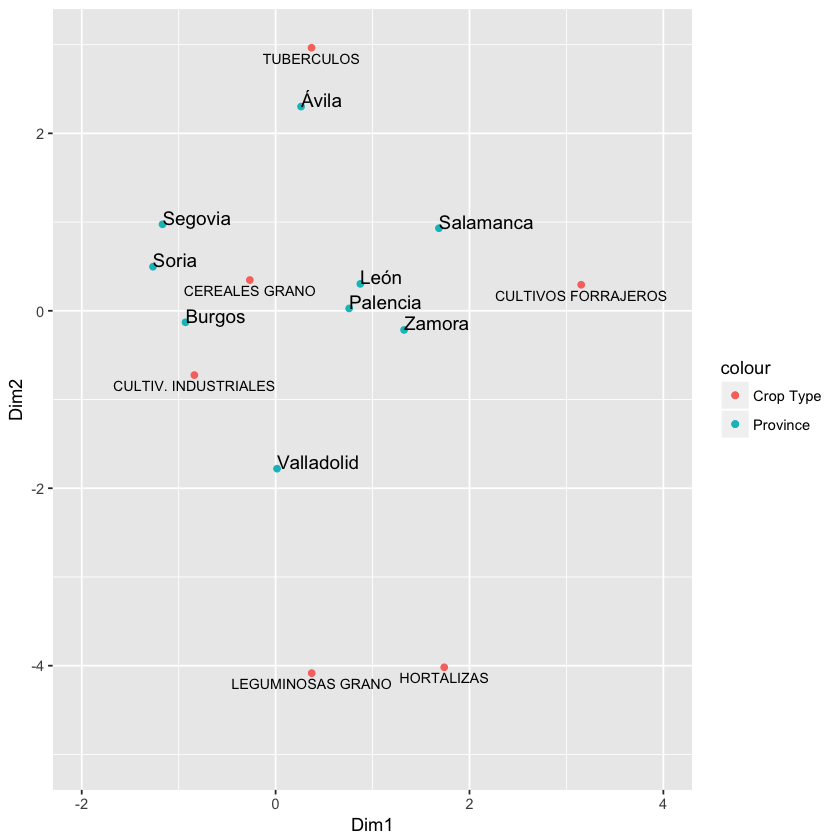

In [14]:
ggplot(mapping = aes(x =Dim1, y = Dim2 )) +
    geom_point(data = as.data.frame(crops.herbaceous.use.ca$colcoord), 
               mapping = aes(colour = 'Province')) + 
    geom_point(data = as.data.frame(crops.herbaceous.use.ca$rowcoord), 
               mapping = aes(colour = 'Crop Type')) + 
    geom_text(data = as.data.frame(crops.herbaceous.use.ca$rowcoord),
              label=rownames(crops.herbaceous.use.ca$rowcoord), 
              hjust=0.5, vjust=1.5, size = 3) +
    geom_text(data = as.data.frame(crops.herbaceous.use.ca$colcoord),
              label=rownames(crops.herbaceous.use.ca$colcoord), 
              hjust=0, vjust=0, size = 4) +
    coord_cartesian(xlim = c(-2, 4), ylim = c(-5, 3)) 
